In [87]:
include("../src/JuliaMBD.jl")

Main.JuliaMBD

In [88]:
using DifferentialEquations
using Plots
import .JuliaMBD

In [89]:
## MSD

function MSD(;M, D, k, g = 9.8)
    b = JuliaMBD.SubSystemBlock(:MSD)

    JuliaMBD.addparameter!(b, :M, M)
    JuliaMBD.addparameter!(b, :D, D)
    JuliaMBD.addparameter!(b, :k, k)
    JuliaMBD.addparameter!(b, :g, g)

    in1 = JuliaMBD.Inport(:in1)
    JuliaMBD.add!(b, in1)

    out1 = JuliaMBD.Outport(:out1)
    JuliaMBD.add!(b, out1)

    constant1 = JuliaMBD.Constant(value = :(M*g))
    JuliaMBD.add!(b, constant1)

    gain1 = JuliaMBD.Gain(K = :D)
    JuliaMBD.add!(b, gain1)

    gain2 = JuliaMBD.Gain(K = :k)
    JuliaMBD.add!(b, gain2)

    gain3 = JuliaMBD.Gain(K = :(1/M))
    JuliaMBD.add!(b, gain3)

    int1 = JuliaMBD.Integrator(sin = JuliaMBD.OutPort(:int1sin), sout = JuliaMBD.OutPort(:int1sout))
    JuliaMBD.add!(b, int1)

    int2 = JuliaMBD.Integrator(initialcondition = :(M*g/k), sin = JuliaMBD.OutPort(:int2sin), sout = JuliaMBD.OutPort(:int2sout))
    JuliaMBD.add!(b, int2)

    sum1 = JuliaMBD.Add(signs=[:+, :+, :-, :-])
    JuliaMBD.add!(b, sum1)

    JuliaMBD.LineSignal(in1.env[:out], sum1.env[:in1])
    JuliaMBD.LineSignal(constant1.env[:out], sum1.env[:in2])
    JuliaMBD.LineSignal(gain1.env[:out], sum1.env[:in3])
    JuliaMBD.LineSignal(gain2.env[:out], sum1.env[:in4])
    JuliaMBD.LineSignal(sum1.env[:out], gain3.env[:in])

    JuliaMBD.LineSignal(gain3.env[:out], int1.env[:in])
    JuliaMBD.LineSignal(int1.env[:out], int2.env[:in])
    JuliaMBD.LineSignal(int1.env[:out], gain1.env[:in])

    JuliaMBD.LineSignal(int2.env[:out], gain2.env[:in])
    JuliaMBD.LineSignal(int2.env[:out], out1.env[:in])

    JuliaMBD.addscope!(b, :x, out1.env[:in])
    JuliaMBD.addscope!(b, :x2, gain3.env[:out])
    b
end

MSD (generic function with 1 method)

In [90]:
## test

function Test(;M, D, k, f, p_cycle, p_width)
    b = JuliaMBD.SubSystemBlock(:Test)

    JuliaMBD.addparameter!(b, :M, M)
    JuliaMBD.addparameter!(b, :D, D)
    JuliaMBD.addparameter!(b, :k, k)
    JuliaMBD.addparameter!(b, :f, f)
    JuliaMBD.addparameter!(b, :p_cycle, p_cycle)
    JuliaMBD.addparameter!(b, :p_width, p_width)
    # JuliaMBD.addparameter!(b, :g, 9.8)

    msd = MSD(M=:M, D=:D, k=:k)
    JuliaMBD.add!(b, msd)

    pulse = JuliaMBD.PulseGenerator(amplitude=f, period=p_cycle, pulsewidth=p_width, phasedelay=10.0)
    JuliaMBD.LineSignal(b.timeport, pulse.env[:time])
    JuliaMBD.add!(b, pulse)

    JuliaMBD.LineSignal(pulse.env[:out], msd.env[:in1])

    JuliaMBD.addscope!(b, :F, pulse.env[:out])
    b
end

Test (generic function with 1 method)

In [91]:
b = MSD(M=10, D=10, k=10)
b = Test(M=10, D=10, k=10, f=10, p_cycle=20, p_width=50)
JuliaMBD.expr_sfunc(b)

:(function Test_sfunc(int1sin, int2sin; M = 10, D = 10, k = 10, f = 10, p_cycle = 20, p_width = 50, g = 9.8, time = 0)
      var"##1361" = M * g
      begin
          var"##1390" = int2sin
          var"##1391" = int2sin
      end
      begin
          var"##1398" = time
      end
      var"##1393" = var"##1398"
      begin
          var"##1388" = int1sin
          var"##1389" = int1sin
      end
      var"##1365" = var"##1390"
      var"##1370" = 1 / M
      var"##1395" = 20
      var"##1396" = 50
      var"##1360" = var"##1361"
      var"##1376" = (nothing, nothing)
      var"##1375" = (M * g) / k
      var"##1373" = (nothing, nothing)
      var"##1372" = 0.0
      var"##1394" = 10
      var"##1364" = D
      var"##1397" = 10.0
      begin
          #= /workspaces/JuliaMBD/src/predefined/Sources/PulseGenerator.jl:27 =#
          var"##1392" = if var"##1393" < var"##1397"
                  #= /workspaces/JuliaMBD/src/predefined/Sources/PulseGenerator.jl:28 =#
                  0
     

In [92]:
b = Test(M=10, D=1, k=10, f=100, p_cycle=20, p_width=50)

"Block(Test)"

In [93]:
eval(JuliaMBD.expr_sfunc(b))
eval(JuliaMBD.expr_ofunc(b))
eval(JuliaMBD.expr_ifunc(b))
eval(JuliaMBD.expr_pfunc(b))
m = JuliaMBD.ODEModel(
    b,
    eval(JuliaMBD.expr_odemodel_pfunc(b)),
    eval(JuliaMBD.expr_odemodel_ifunc(b)),
    eval(JuliaMBD.expr_odemodel_sfunc(b)),
    eval(JuliaMBD.expr_odemodel_ofunc(b))
);

  0.002083 seconds (4.08 k allocations: 428.594 KiB)


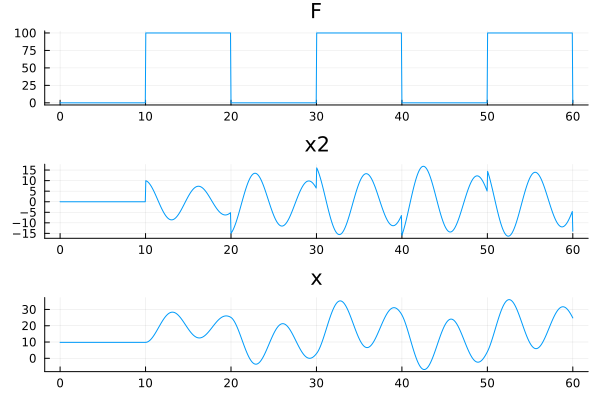

In [98]:
@time begin
    result = JuliaMBD.simulate(m, (0.0, 60.0))
    plot(result, layout=(3,1))
end